# Сборный проект №2

**Описание  проекта**

Я работаю в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения. 

Для этого:

1) Изучим воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

2) После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

3) Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

4) В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.


**Проект будет разделен на 5 шагов.**



### Шаг 1. Откроем файл с данными и изучим общую информацию.

In [1]:
#загружаем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats as st
import math as mth

In [2]:
#загрузим датафрейм
data = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')

In [3]:
#изучим общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


**Вывод**

Загрузили датафрейм. Видим что наименование столбцов ниобходимо привести к "змеином" регистру.
Видим так же "проблемы" с типом данных в имеющейся таблице.

### Шаг 2. Подготовим данные для дальнейшего анализа

In [5]:
#переименуем стобцы
data = data.rename(
    columns={'EventName':'event_name', 'DeviceIDHash':'device_id', 'EventTimestamp':'event_time', 'ExpId':'group'})

In [6]:
#проверим на пропуски:
data.isna().sum()

event_name    0
device_id     0
event_time    0
group         0
dtype: int64

In [7]:
#проверим на явные дубликаты:
data.duplicated().sum()

413

Видим 413 явных дубликатов. Выясним сколько это % информации от общего количества

In [8]:
print(f"доля дубликатов {data.duplicated().sum()/data['device_id'].count():.1%}")

доля дубликатов 0.2%


Видим, что даля дубликатов составляет 0,2%. Считаем что от от данных дубликатов можно избавиться.

In [9]:
data = data.drop_duplicates().reset_index(drop=True)

In [10]:
#Проверяем
data.duplicated().sum()

0

In [11]:
#Приобразовываем формат даты
data.event_time = pd.to_datetime(data.event_time, unit='s')

In [12]:
#Добавляем отдельный столбец дат
data['event_date'] = data.event_time.dt.date

In [13]:
# Проверяем, что получилось
display(data.head())
display(data.info())

,event_name,device_id,event_time,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   device_id   243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   event_date  243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


None

In [14]:
#создадим списки уникальных пользователей в каждой группе
gr246 = data.query('group == 246')['device_id'].unique()
gr247 = data.query('group == 247')['device_id'].unique()
gr248 = data.query('group == 248')['device_id'].unique()

In [15]:
#проверим пересечения в группах 246 и 247
intersection_1 = []
for i in gr246:
  if i in gr247:
    intersection_1.append(i)
print(len(intersection_1))

0


In [16]:
#проверим пересечения в группах 246 и 248
intersection_2 = []
for i in gr246:
  if i in gr248:
    intersection_2.append(i)
print(len(intersection_2))

0


In [17]:
#проверим пересечения в группах 247 и 248
intersection_3 = []
for i in gr247:
  if i in gr248:
    intersection_3.append(i)
print(len(intersection_3))

0


**Вывод**

Привели наименование столбцов к "змеиному" регистру.

Проверили на пропуски и дублицаты датафрейм. Доля дубликатов составли 0,2% от всего датафрейма. Приняли решение удалить дубликаты.

Отредактировали тип данных в стобце даты и времени, а так же создали отдельный столбец дат.

### Шаг 3. Изучим и проверим данные более детально

In [18]:
#количество событий в логе
print(f"количество событий в логе {data['event_name'].count()}")

количество событий в логе 243713


In [19]:
#количество всего пользователей
print(f"количество уникальных пользователей {data['device_id'].nunique()}")

количество уникальных пользователей 7551


In [20]:
#количество событий на пользователя в среднем
print(f"В среднем {int(len(data) / len(data.device_id.unique()))} событий приходятся на 1 пользователя")

В среднем 32 событий приходятся на 1 пользователя


In [21]:
data.groupby('device_id')[['event_name']].count().describe(percentiles=[1/4, 1/2, 3/4])

,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


In [22]:
#минимальная дата:
print(data['event_time'].min())

2019-07-25 04:43:36


In [23]:
#максимальная дата:
print(data['event_time'].max())

2019-08-07 21:15:17


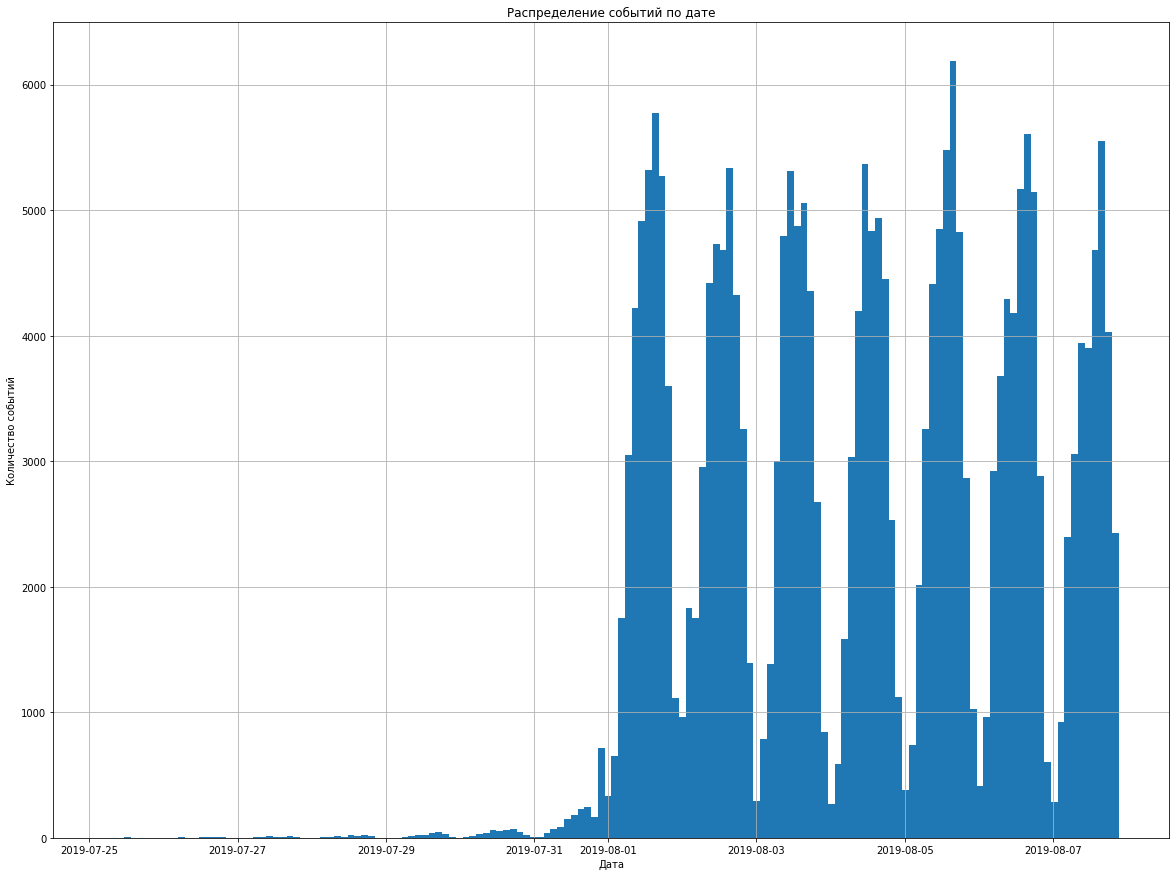

In [24]:
#построим график для наглядности
data['event_time'].hist(bins=150,  figsize=(20, 15))
plt.title('Распределение событий по дате')
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.show()

Даны данные с 25.07.19 по 07.08.2019, однако по гистограмме видим что мы обладает полными данными только с 01.08.19.

In [25]:
#удалим период с неполными датами:
actual_data = data.query('event_time >= "2019-08-01"')

In [26]:
#посчитаем потерю событий:
print(f"количество потерянных событий {len(data) - len(actual_data)}")
print(f"доля потерянных событий {(len(data) - len(actual_data))/len(data):.1%}")
print(f"количество потерянных пользователей {data['device_id'].nunique()- actual_data['device_id'].nunique()}")
print(f"доля потерянных пользователей {(data['device_id'].nunique() - actual_data['device_id'].nunique())/data['device_id'].nunique():.1%}")

количество потерянных событий 2826
доля потерянных событий 1.2%
количество потерянных пользователей 17
доля потерянных пользователей 0.2%


Количество потерь не большое, по этому принимаем их и продолжаем работу.

In [27]:
#проверим, есть ли пользователи из всех трёх экспериментальных групп.
print (actual_data.groupby('group')['device_id'].nunique())

group
246    2484
247    2513
248    2537
Name: device_id, dtype: int64


**Вывод**

1) Определили количество событий в логе, их 243 713

2) Определили количество пользователей в логе, их 7 551

3) Определили количетсво событий в среднем на пользователя, их 20

4) Определили минимальную и максимальную дату событий: 2019-07-25 и 2019-08-07 соответственно, однако полные данные оказались лишь 2019-08-01 по 2019-08-07;

5) Обросили неполные данные и посчитали потери:

* потеря событий всего 2826 из 243713 (1,2%)
* потеря пользователей 17 из 7551 (0,2%)

### Шаг 4. Изучим воронку событий

In [28]:
#Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.
actual_data.groupby('event_name').agg(count = ('device_id', 'count')).sort_values(by = 'count', ascending=False)

,count
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


In [29]:
#Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей.
event_users = actual_data.groupby('event_name').agg(users=('device_id','nunique')).sort_values('users', ascending=False)
event_users

,users
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [30]:
#Посчитаем долю пользователей, которые хоть раз совершали событие.
event_users['ratio'] = round(event_users['users']/actual_data['device_id'].nunique() * 100, 2)
event_users

,users,ratio
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


**Необходимо определить в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?**

Предположим, что пользователь:

* сначала открывает главную страницу приложения(MainScreenAppear);
* потом в каталоге выбирает товары(OffersScreenAppear);
* кладёт их в корзину(CartScreenAppear);
* оплачивает(PaymentScreenSuccessful).

Tutorial(обучение) - не входит в эту последовательность так как не является обязательным этапом (если приложение достаточно дружелюбное).

In [31]:
#По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки

#создадим сводную таблицу с количеством уникальных пользователей совершавших каждое из событий
event_users = data.query('event_name != "Tutorial"').pivot_table(index = 'event_name', values = 'device_id', aggfunc = 'nunique').sort_values(by = 'device_id', ascending = False)
#добавим столбец со смещенными значениями количества пользователей методом shift
#недостающее значение заполним первым значением столбца параметром fill_value
event_users['shift'] = event_users['device_id'].shift(1, fill_value = event_users['device_id'].loc[event_users.index[0]])
#посчитаем и добавим столбец с конверсией округленной до 1 десятка
event_users['conversion'] = round(event_users['device_id']/event_users['shift'] * 100, 1)
#в итоговой таблице оставим только количество уникальных пользователей и конверсией
event_users = event_users[['device_id', 'conversion']]
event_users

,device_id,conversion
event_name,,
MainScreenAppear,7439,100.0
OffersScreenAppear,4613,62.0
CartScreenAppear,3749,81.3
PaymentScreenSuccessful,3547,94.6


Исходя из таблицы выше, больше всего пользователей теряется после первого шага (MainScreenAppear). Порядка 2 826 пользователей (38%).

In [32]:
#Посчитаем, какая доля пользователей доходит от первого события до оплаты
print(f"Доля пользователей прошедших от первого события до оплаты {event_users['device_id'].loc[event_users.index[-1]]/event_users['device_id'].loc[event_users.index[0]]:.1%}")

Доля пользователей прошедших от первого события до оплаты 47.7%


**Вывод**

Посмотрели, как часто встречаются события в логе.

Посчитали, сколько пользователей совершали каждое из этих событий и долю пользователей, которые хоть раз совершали событие.

Предположили, в каком порядке происходят события:

По воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем):

* на первом шаге 7419 пользователей;
* до второго шага доходит 4613 пользователей, доля от предыдущего шага 62.0%;
* до третьего шага доходит 3749 пользователей, доля от предыдущего шага 81.3%;
* до четвертого шага доходит 3547, доля от предыдущего шага 94.6%

Определили, что больше всего пользователей теряется на первом шаге: доля оплативших товар от тех кто дошел до просмотра корзины 62.0%.

Посчитали, что доля пользователей прошедших от первого события до оплаты 47.7%.

### Шаг 5. Изучим результаты эксперимента.

In [33]:
#Посчитаем, пользователей в каждой экспериментальной группе
actual_data.pivot_table(index = 'group', values = 'device_id', aggfunc = 'nunique')

,device_id
group,
246,2484
247,2513
248,2537


Всего имеются три группы пользователей: 

группы 246 и 247 - контрольные, 

группа 248 - экспериментальная. 

В них соответственно по 2484, 2513 и 2537 человек.

Есть незначительная разница в количестве пользователей в каждой эксперементальной группе.

**Проверим, находят ли статистические критерии разницу между выборками 246 и 247.
Критерии успешного A/A-теста:**

* Количество пользователей в различных группах различается не более, чем на 1%;

* Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;

* Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;

* Попавший в одну из групп посетитель остаётся в этой группе до конца теста.

In [34]:
for i in range(0, 3):
    gr_list = [246, 247, 248, 246]
    print(f'Разница между группой {gr_list[i]} и {gr_list[i+1]} составляет {1 - actual_data.query("group == @gr_list[@i]")["device_id"].nunique() / actual_data.query("group == @gr_list[@i+1]")["device_id"].nunique():.2%}')

Разница между группой 246 и 247 составляет 1.15%
Разница между группой 247 и 248 составляет 0.95%
Разница между группой 248 и 246 составляет -2.13%


Количество пользователей в каждой из групп достаточно большое для проведения исследования и разница между размерами групп не большая. 

Проверить, как зафиксированы и отправлены логи, мы не можем - остается положиться на источник данных.

**Выберем самое популярное событие.**

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. 

Проверим, будет ли отличие между группами статистически достоверным. 

In [35]:
gr_246 = actual_data.query('group == 246')
gr_247 = actual_data.query('group == 247')
gr_248 = actual_data.query('group == 248')

In [36]:
gr_246.pivot_table(index = 'event_name', values = 'device_id', aggfunc = 'nunique'
                  ).sort_values(by = 'device_id', ascending = False)

,device_id
event_name,
MainScreenAppear,2450
OffersScreenAppear,1542
CartScreenAppear,1266
PaymentScreenSuccessful,1200
Tutorial,278


In [37]:
gr_247.pivot_table(index = 'event_name', values = 'device_id', aggfunc = 'nunique'
                  ).sort_values(by = 'device_id', ascending = False)

,device_id
event_name,
MainScreenAppear,2476
OffersScreenAppear,1520
CartScreenAppear,1238
PaymentScreenSuccessful,1158
Tutorial,283


**Сформируем гипотезы:**

* H0: Между долями статистической значимой разницы нет, поведение групп не отличается;

* H1: Между долями статистическая значимая разница есть, поведение групп отличается.

Закрепим критический уровент статистической значемости = 0.05

In [38]:
#Для дальнейшей работы напимем функцию
def test(g1, g2, event_name, alpha):
    
    users_event = np.array([g1[g1['event_name'] == event_name]['device_id'].nunique(), g2[g2['event_name'] == event_name]['device_id'].nunique()])
        
    users_group = np.array([g1['device_id'].nunique(), g2['device_id'].nunique()])
    
    p1 = users_event[0]/users_group[0]
    p2 = users_event[1]/users_group[1]
    
    p_combin = (users_event[0] + users_event[1]) / (users_group[0] + users_group[1])
    
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combin * (1 - p_combin) * (1/users_event[0] + 1/users_event[1]))
    
    distr = st.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(event_name)
          
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print()

In [39]:
#создадим список с уникальными событиями:
event_name_unique = data['event_name'].unique()

#создадим цикл, который будет подставлять в функцию уникальные значения собитый:
for event_name in event_name_unique[:-1]:
    test(gr_246, gr_247, event_name, 0.05)

MainScreenAppear
p-значение:  0.758737151572354
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.2784401253423807
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.39432110136773835
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.36593695068605325
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Делаем вывод**

Статистические критерии разницу между выборками 246 и 247 не находят, т.к. ни для одного из событий разница не оказалось значимой, обе эти группы можно считать контрольными, так же разбиение на группы работает корректно.

**Аналогично поступим с группой с изменённым шрифтом.**

Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой.

In [40]:
for event_name in event_name_unique[:-1]:
    test(gr_246, gr_248, event_name, 0.05)

MainScreenAppear
p-значение:  0.2987450335656847
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.3903369220965023
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.21469452387393084
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.32498018019986397
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод**

Значимой разницы в поведении пользователей групп 246 и 248 нет

In [41]:
#Проверим 2 контрольную группу 247 с группой с изменным шрифтом 248
for event_name in event_name_unique[:-1]:
    test(gr_246, gr_248, event_name, 0.05)

MainScreenAppear
p-значение:  0.2987450335656847
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.3903369220965023
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.21469452387393084
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.32498018019986397
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод**

Значимой разницы в поведении пользователей групп 247 и 248 нет

In [42]:
#создадим группы 
gr_246_247 = pd.concat([gr_246, gr_247])

#И проверим объедененную контрольную группу с группой с изменным шрифтом 248
for event_name in event_name_unique[:-1]:
    test(gr_246_247, gr_248, event_name, 0.05)

MainScreenAppear
p-значение:  0.2982116211407275
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.7202057779473505
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.34982490083868933
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.5425331263544062
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Какой уровень значимости мы выбрали при проверке статистических гипотез выше. Посчитаем, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.**

In [43]:
#убедимся, что 0.05 без корректировки нам не подходит
p_value_cor1 = 1 - (1 - 0.05)**16
print('p-value без корректировки:', p_value_cor1)

p-value без корректировки: 0.5598733313482347


**Вывод:**
Так как полученное значение больше применяемого нами значения alpha, делаем вывод что нужна поправка уровня значимости.

In [44]:
alpha_new = 1 - (1 - 0.05)**(1 / 16)
print('Уточненное значение alpha:', alpha_new)

Уточненное значение alpha: 0.0032006977101884937


In [45]:
#Убедимся, что 0.05 с корректировкой нам подходит.
p_value_cor2 = 1 - (1 - alpha_new)**16
print('Скорректированный p-value:', p_value_cor2)

Скорректированный p-value: 0.04999999999999993


**Вывод**

Полученное значение хоть и очень близко к нашему значению alpha приминяемого в тестах, но все же меньше.
Исходя из полученного результата делаем вывод, что текущий уровень значимости актуален.

### Общий Вывод

В ходе исследования мы изучили данные о работе мобильного приложения-магазина. 

Данные были получены в ходе проведения эксперимента. Нулевой гипотезой было предположение, что выбранный дизайнерами шрифт не влияет на взаимодействие пользователей с приложением. Отвергнуть эту гипотезу не удалось, по-видимому, шрифт действительно не влияет на пользователей, либо новый шрифт так же удобен и читаем, как старый. 

**Рекомендация коллегам:**
Наибольший скачок в воронке наблюдается между начальной страницей приложения и каталогом - этот этап не проходят почти 40% пользователей. Возможно, следует поискать проблему в этом этапе.